In [5]:
# Render our plots inline
%matplotlib inline
import time
import pandas as pd
import matplotlib.pyplot as plt

# Make the graphs a bit prettier, and bigger
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

# 1.1 Members data

In this notebook we are going to look at [Kubernetes London](https://www.meetup.com/Kubernetes-London/) members data downloaded from [meetup.com](https://www.meetup.com/).

You can download the members "Excel" (it's not actually Excel sheet -- FFS Meetup -- hence the double quotes) sheet by navigating to *Members* section of your group and then clicking on *Download member list* link.

You can read the group data from the downloaded `.xls` member file using the `read_csv` pandas function. See the docs [here](http://pandas.pydata.org/pandas-docs/stable/io.html#io-excel-reader).

In [6]:
# path to members data
members_path = 'data/Kubernetes-London_Member_List_on_2018-11-28.xls'

# Meetup stores bool values as Yes/No strings (<facepalm/>) - we need to convert those
# lambda fn to convert Yes/No fields to True/False i.e. to boolean values
boolfn = lambda x: True if x == 'Yes' else False

# read in meetup members data
members = pd.read_csv(members_path, 
                      sep='\t', 
                      parse_dates=['Joined Group on', 'Last visited group on', 'Last Attended'],
                      converters={'Intro' : boolfn,
                                  'Photo' : boolfn,
                                  'Assistant Organizer':boolfn,
                                  'Mailing List' : boolfn})

# let's rename some of these skanky long column names
members.rename(columns={'Joined Group on' : 'Joined', 'Last visited group on' : 'Last Visited'}, inplace=True)
members.head()

,Name,User ID,Title,Member ID,Location,Joined,Last Visited,Last Attended,Total RSVPs,RSVPed Yes,RSVPed Maybe,RSVPed No,Meetups attended,No shows,Intro,Photo,Assistant Organizer,Mailing List,URL of Member Profile
0,Ricardo Perez,user 170615672,NaN,170615672,London,2018-05-25,2018-06-06,NaT,0,0,0,0,0,0,False,False,False,True,https://www.meetup.com/Kubernetes-London/membe...
1,@michcov,user 182737081,NaN,182737081,London,2017-08-19,2018-02-18,NaT,0,0,0,0,0,0,False,True,False,True,https://www.meetup.com/Kubernetes-London/membe...
2,A Galp,user 227151009,NaN,227151009,Edgware,2017-05-07,2017-06-13,2017-05-11,2,1,0,1,1,0,False,False,False,True,https://www.meetup.com/Kubernetes-London/membe...
3,A Memon,user 227306568,NaN,227306568,London,2017-11-29,2017-11-30,2017-12-01,1,1,0,0,1,0,False,False,False,True,https://www.meetup.com/Kubernetes-London/membe...
4,Aanjaneya Mishra,user 13661634,NaN,13661634,London,2016-05-22,2016-05-23,2016-05-24,1,1,0,0,1,0,False,True,False,True,https://www.meetup.com/Kubernetes-London/membe...


## 1.1.1 Members growth over time

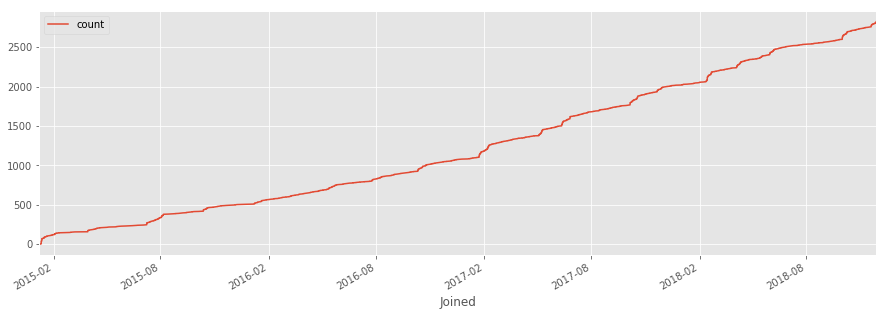

In [7]:
growth = members[['Joined']].copy()
growth['count'] = 1
growth.set_index('Joined', inplace=True)
growth.sort_index().cumsum().plot()
plt.show()

# 1.2 Events data

Since Meetup doesn't provide any event related data other than via its API. There is a small script, `meetup.py`, available in `utils` directory. The script fetches the events data via Meetup API (note that it fetches first 200 events -- no pagination is implemented) and writes selected fields into `events.csv` file on the local drive.

In [8]:
# path to events data
events_path = 'data/events.csv'

# read in meetup events and index by date_time. We also mark the placeholder events values NaN
events = pd.read_csv(events_path,
                     na_values={'rsvp_limit' : [0]},
                     parse_dates=[['date', 'time']],
                     index_col='date_time')

# we will rename 'date_time' to 'date'
events.index.name = 'date'

# we need to convert announced field into date
events['announced'] = pd.to_datetime(events['announced'], unit='ms')

# we will add a 'available_spots' column; available_spots contains %-age of available event spots
events['available_spots'] = events['rsvp_limit'] - events['rsvp_yes']
events.head()

,announced,venue,name,rsvp_limit,rsvp_yes,waitlist,available_spots
date,,,,,,,
2018-10-09 18:30:00,2018-10-01 09:57:07,Net A Porter,Autumn Kubernetes huddle,200.0,199,0,1.0
2018-09-26 08:30:00,2018-09-21 14:22:00,Code Node,Cloud Native London Raffle,NaN,85,0,NaN
2018-08-28 19:00:00,2018-08-22 14:38:22,Microsoft Reactor,Container Camp Super Meetup,3.0,3,0,0.0
2018-06-07 18:00:00,2018-05-30 13:55:07,Skills Matter CodeNode,Almost summer edition,250.0,235,0,15.0
2018-05-17 18:30:00,2018-05-11 15:10:10,Deliveroo HQ,Kubernetes May Edition,3.0,3,0,0.0


## 1.2.1 Events available spots

Show which events had the most available spots - can signal big dropout. Unfortunately Meetup doesnt provide any data about members which initially signed up but then change their RSVP to **no**, so the chart below does not indicate **dropout** counts.

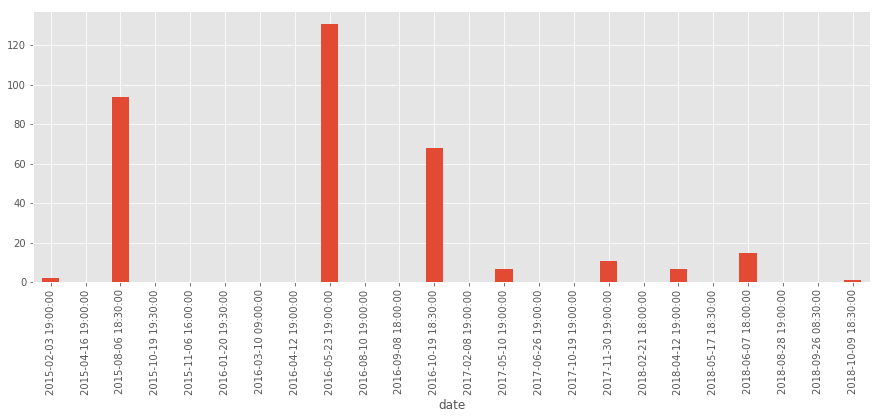

In [9]:
events['available_spots'].sort_index().plot(kind='bar')
plt.show()

## 1.2.2 Top 5 events with highest number of available spots

In [10]:
events.sort_values(by=['available_spots'], ascending=False)[:5]

,announced,venue,name,rsvp_limit,rsvp_yes,waitlist,available_spots
date,,,,,,,
2016-05-23 19:00:00,2016-05-13 02:16:00,Skills Matter CodeNode,Kubernetes Vol. 7,300.0,169,0,131.0
2015-08-06 18:30:00,2015-07-09 12:45:22,Skills Matter CodeNode,Kubernetes launch London party!,300.0,206,0,94.0
2016-10-19 18:30:00,2016-10-09 23:31:35,Skills Matter CodeNode,Autumn Kubernetes gathering,250.0,182,0,68.0
2018-06-07 18:00:00,2018-05-30 13:55:07,Skills Matter CodeNode,Almost summer edition,250.0,235,0,15.0
2017-11-30 19:00:00,2017-11-21 12:51:58,Skills Matter CodeNode,Kuber-X-mas gathering,240.0,229,0,11.0


## 1.2.3 Plot highest number of available spots per weekday

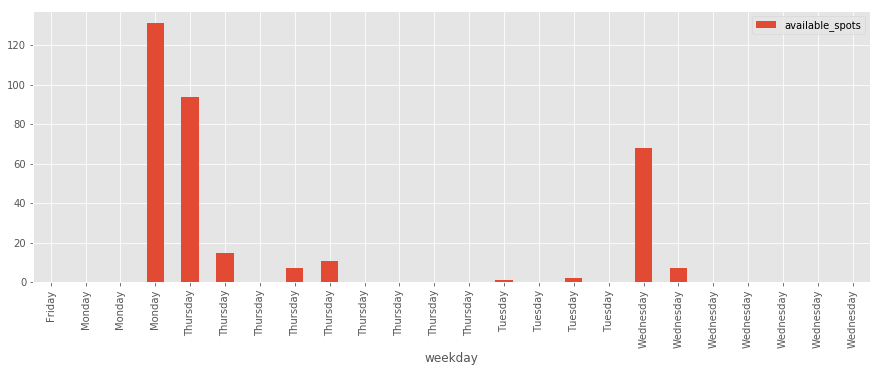

In [11]:
spots = events[['available_spots']].copy()
spots['weekday'] = spots.index.weekday_name
spots.set_index('weekday', inplace=True)
spots.sort_index().plot(kind='bar')
plt.show()

# 1.3 Combined members and events data

In this section you can play around with combined members and events dataframes. See some basic examples below

### 1.3.1 Joins on event announcement

You can see that Kubernetes London member joins correlate with event announcements

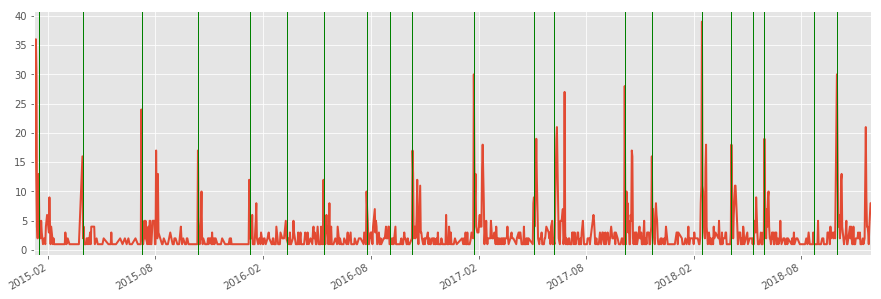

In [12]:
joins = members[['Joined']].copy()
ax = joins['Joined'].value_counts().plot(linewidth=2)
event = events.dropna()[['announced']]
[ax.axvline(a, linewidth=1, color='g') for a in event['announced']]
plt.show()